![cyber_photo](cyber_photo.jpg)

Cyber threats are a growing concern for organizations worldwide. These threats take many forms, including malware, phishing, and denial-of-service (DOS) attacks, compromising sensitive information and disrupting operations. The increasing sophistication and frequency of these attacks make it imperative for organizations to adopt advanced security measures. Traditional threat detection methods often fall short due to their inability to adapt to new and evolving threats. This is where deep learning models come into play.

Deep learning models can analyze vast amounts of data and identify patterns that may not be immediately obvious to human analysts. By leveraging these models, organizations can proactively detect and mitigate cyber threats, safeguarding their sensitive information and ensuring operational continuity.

As a cybersecurity analyst, you identify and mitigate these threats. In this project, you will design and implement a deep learning model to detect cyber threats. The BETH dataset simulates real-world logs, providing a rich source of information for training and testing your model. The data has already undergone preprocessing, and we have a target label, `sus_label`, indicating whether an event is malicious (1) or benign (0).

By successfully developing this model, you will contribute to enhancing cybersecurity measures and protecting organizations from potentially devastating cyber attacks.


### The Data

| Column     | Description              |
|------------|--------------------------|
|`processId`|The unique identifier for the process that generated the event - int64 |
|`threadId`|ID for the thread spawning the log - int64|
|`parentProcessId`|Label for the process spawning this log - int64|
|`userId`|ID of user spawning the log|Numerical - int64|
|`mountNamespace`|Mounting restrictions the process log works within - int64|
|`argsNum`|Number of arguments passed to the event - int64|
|`returnValue`|Value returned from the event log (usually 0) - int64|
|`sus_label`|Binary label as suspicous event (1 is suspicious, 0 is not) - int64|

More information on the dataset: [BETH dataset](accreditation.md)

In [1]:
# importing all the libraries I'll need
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torchmetrics import Accuracy
import matplotlib.pyplot as plt
import seaborn as sns

# just in case I need to reproduce results
torch.manual_seed(42)
np.random.seed(42)

## Step 1: Load and Explore the Data

First, let me load the data and take a look at what we're working with.

In [2]:
# loading the datasets
train_df = pd.read_csv('../data/labelled_train.csv')
test_df = pd.read_csv('../data/labelled_test.csv')
val_df = pd.read_csv('../data/labelled_validation.csv')

print("Data loaded successfully!")
print(f"Training set: {train_df.shape}")
print(f"Test set: {test_df.shape}")
print(f"Validation set: {val_df.shape}")

Data loaded successfully!
Training set: (763144, 8)
Test set: (188967, 8)
Validation set: (188967, 8)


In [3]:
# let's look at the first few rows to understand the structure
train_df.head(10)

,processId,threadId,parentProcessId,userId,mountNamespace,argsNum,returnValue,sus_label
0,381,7337,1,100,4026532231,5,0,1
1,381,7337,1,100,4026532231,1,0,1
2,381,7337,1,100,4026532231,0,0,1
3,7347,7347,7341,0,4026531840,2,-2,1
4,7347,7347,7341,0,4026531840,4,0,1
5,7347,7347,7341,0,4026531840,4,3,1
6,7347,7347,7341,0,4026531840,2,0,1
7,7347,7347,7341,0,4026531840,1,0,1
8,7347,7347,7341,0,4026531840,4,0,1
9,7347,7347,7341,0,4026531840,4,3,1


In [4]:
# checking for any missing values
print("Missing values in training set:")
print(train_df.isnull().sum())
print("\nData types:")
print(train_df.dtypes)

Missing values in training set:
processId          0
threadId           0
parentProcessId    0
userId             0
mountNamespace     0
argsNum            0
returnValue        0
sus_label          0
dtype: int64

Data types:
processId          int64
threadId           int64
parentProcessId    int64
userId             int64
mountNamespace     int64
argsNum            int64
returnValue        int64
sus_label          int64
dtype: object


In [5]:
# getting basic statistics about the features
train_df.describe()

,processId,threadId,parentProcessId,userId,mountNamespace,argsNum,returnValue,sus_label
count,763144.000000,763144.000000,763144.000000,763144.000000,7.631440e+05,763144.000000,763144.000000,763144.000000
mean,6814.763308,6820.265241,1882.216609,2.279034,4.026532e+09,2.672082,17.520924,0.001663
std,1948.871187,1937.068333,2215.563094,37.416576,1.649030e+02,1.340906,318.596662,0.040744
min,1.000000,1.000000,0.000000,0.000000,4.026532e+09,0.000000,-115.000000,0.000000
25%,7313.000000,7313.000000,187.000000,0.000000,4.026532e+09,1.000000,0.000000,0.000000
50%,7365.000000,7365.000000,1385.000000,0.000000,4.026532e+09,3.000000,0.000000,0.000000
75%,7415.000000,7415.000000,1648.000000,0.000000,4.026532e+09,4.000000,4.000000,0.000000
max,8619.000000,8619.000000,7672.000000,1000.000000,4.026532e+09,5.000000,8289.000000,1.000000


### Understanding the Target Variable

Let me check how balanced or imbalanced our dataset is. This is important for training!

In [6]:
# checking the distribution of suspicious vs benign events
print("Training set distribution:")
print(train_df['sus_label'].value_counts())
print(f"\nPercentage:")
print(train_df['sus_label'].value_counts(normalize=True) * 100)

print("\n" + "="*50)
print("\nTest set distribution:")
print(test_df['sus_label'].value_counts())
print(f"\nPercentage:")
print(test_df['sus_label'].value_counts(normalize=True) * 100)

print("\n" + "="*50)
print("\nValidation set distribution:")
print(val_df['sus_label'].value_counts())
print(f"\nPercentage:")
print(val_df['sus_label'].value_counts(normalize=True) * 100)

Training set distribution:
sus_label
0    761875
1      1269
Name: count, dtype: int64

Percentage:
sus_label
0    99.833714
1     0.166286
Name: proportion, dtype: float64


Test set distribution:
sus_label
1    171459
0     17508
Name: count, dtype: int64

Percentage:
sus_label
1    90.73489
0     9.26511
Name: proportion, dtype: float64


Validation set distribution:
sus_label
0    188181
1       786
Name: count, dtype: int64

Percentage:
sus_label
0    99.584054
1     0.415946
Name: proportion, dtype: float64


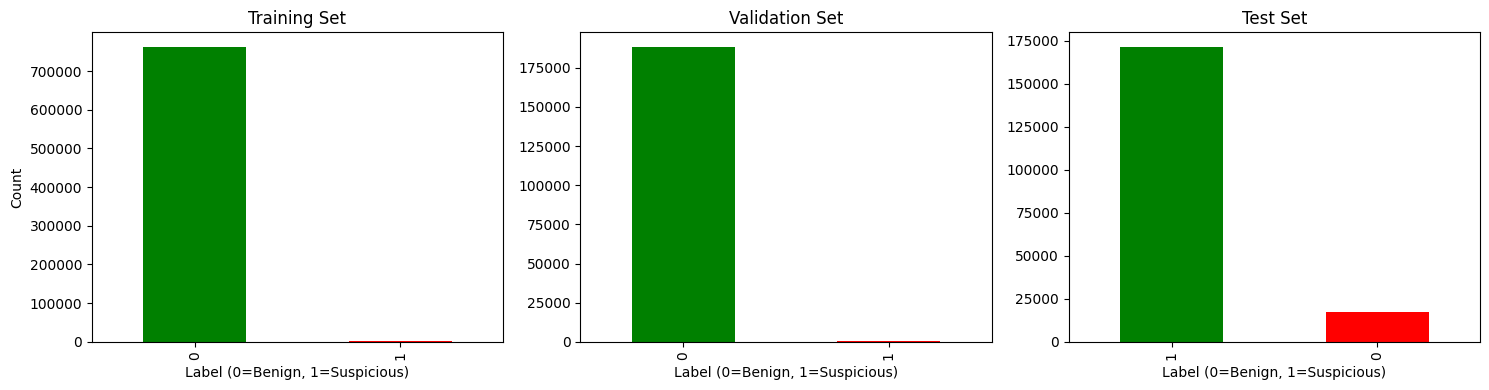

In [7]:
# visualizing the class distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

train_df['sus_label'].value_counts().plot(kind='bar', ax=axes[0], color=['green', 'red'])
axes[0].set_title('Training Set')
axes[0].set_xlabel('Label (0=Benign, 1=Suspicious)')
axes[0].set_ylabel('Count')

val_df['sus_label'].value_counts().plot(kind='bar', ax=axes[1], color=['green', 'red'])
axes[1].set_title('Validation Set')
axes[1].set_xlabel('Label (0=Benign, 1=Suspicious)')

test_df['sus_label'].value_counts().plot(kind='bar', ax=axes[2], color=['green', 'red'])
axes[2].set_title('Test Set')
axes[2].set_xlabel('Label (0=Benign, 1=Suspicious)')

plt.tight_layout()
plt.show()

# Hmm, looks like there might be some class imbalance. This is common in cybersecurity!

## Step 2: Data Preprocessing

Now I need to prepare the data for the neural network. This involves:
1. Separating features from labels
2. Scaling the features (neural networks work better with normalized data)
3. Converting to PyTorch tensors

In [8]:
# separating features (X) and labels (y)
X_train = train_df.drop('sus_label', axis=1).values
y_train = train_df['sus_label'].values

X_val = val_df.drop('sus_label', axis=1).values
y_val = val_df['sus_label'].values

X_test = test_df.drop('sus_label', axis=1).values
y_test = test_df['sus_label'].values

print(f"Training features shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"\nNumber of features: {X_train.shape[1]}")

Training features shape: (763144, 7)
Training labels shape: (763144,)

Number of features: 7


In [9]:
# scaling the features using StandardScaler
# this is important because different features have different ranges
scaler = StandardScaler()

# fit on training data only, then transform all sets
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Features scaled successfully!")
print(f"Mean of scaled training features: {X_train_scaled.mean():.4f}")
print(f"Std of scaled training features: {X_train_scaled.std():.4f}")

Features scaled successfully!
Mean of scaled training features: -0.0000
Std of scaled training features: 1.0000


In [10]:
# converting numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # long for classification

X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

print("Converted to tensors!")
print(f"Training tensor shape: {X_train_tensor.shape}")
print(f"Training tensor dtype: {X_train_tensor.dtype}")

Converted to tensors!
Training tensor shape: torch.Size([763144, 7])
Training tensor dtype: torch.float32


In [11]:
# creating DataLoaders for batch training
# batch_size = 32 seems like a good starting point
batch_size = 32

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Created DataLoaders with batch size: {batch_size}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Created DataLoaders with batch size: 32
Number of training batches: 23849
Number of validation batches: 5906
Number of test batches: 5906


## Step 3: Building the Neural Network

Now comes the fun part - building the neural network! I'll start with a simple architecture:
- Input layer: 7 features
- Hidden layer: Let's try 64 neurons with ReLU activation
- Output layer: 2 classes (benign vs suspicious)

In [12]:
# defining my neural network class
class CyberThreatDetector(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CyberThreatDetector, self).__init__()
        # first layer: input to hidden
        self.fc1 = nn.Linear(input_size, hidden_size)
        # second layer: hidden to output
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # passing input through first layer and ReLU activation
        x = F.relu(self.fc1(x))
        # passing through output layer (no activation here, handled by loss function)
        x = self.fc2(x)
        return x

# model parameters
input_size = 7  # we have 7 features
hidden_size = 64  # trying 64 neurons in hidden layer
output_size = 2  # 2 classes: benign (0) or suspicious (1)

# creating the model
model = CyberThreatDetector(input_size, hidden_size, output_size)

print("Model architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")

Model architecture:
CyberThreatDetector(
  (fc1): Linear(in_features=7, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)

Total parameters: 642


## Step 4: Setting up Training

I need to define:
- Loss function: CrossEntropyLoss (good for classification)
- Optimizer: Adam (usually works well)
- Learning rate: 0.001 is a common starting point

In [13]:
# setting up loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# I'll train for 10 epochs to start
num_epochs = 10

print("Training setup complete!")
print(f"Loss function: CrossEntropyLoss")
print(f"Optimizer: Adam with lr=0.001")
print(f"Number of epochs: {num_epochs}")

Training setup complete!
Loss function: CrossEntropyLoss
Optimizer: Adam with lr=0.001
Number of epochs: 10


## Step 5: Training the Model

Let's train! I'll monitor the validation accuracy after each epoch to see how well it's learning.

In [14]:
# lists to store training history
train_losses = []
val_accuracies = []

print("Starting training...\n")

for epoch in range(num_epochs):
    # Training phase
    model.train()  # set model to training mode
    epoch_loss = 0
    
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        # zero the gradients
        optimizer.zero_grad()
        
        # forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # backward pass and optimization
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    # Validation phase
    model.eval()  # set model to evaluation mode
    val_accuracy = Accuracy(task="binary")
    
    with torch.no_grad():  # no gradients needed for validation
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs.data, 1)
            val_accuracy.update(predicted, y_batch)
    
    val_acc = val_accuracy.compute().item()
    val_accuracies.append(val_acc)
    
    # print progress
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'  Training Loss: {avg_loss:.4f}')
    print(f'  Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)\n')

print("Training complete!")

Starting training...

Epoch [1/10]
  Training Loss: 0.0033
  Validation Accuracy: 1.0000 (100.00%)

Epoch [2/10]
  Training Loss: 0.0019
  Validation Accuracy: 1.0000 (100.00%)

Epoch [3/10]
  Training Loss: 0.0019
  Validation Accuracy: 1.0000 (100.00%)

Epoch [4/10]
  Training Loss: 0.0018
  Validation Accuracy: 1.0000 (100.00%)

Epoch [5/10]
  Training Loss: 0.0018
  Validation Accuracy: 1.0000 (100.00%)

Epoch [6/10]
  Training Loss: 0.0017
  Validation Accuracy: 1.0000 (100.00%)

Epoch [7/10]
  Training Loss: 0.0016
  Validation Accuracy: 1.0000 (100.00%)

Epoch [8/10]
  Training Loss: 0.0016
  Validation Accuracy: 1.0000 (100.00%)

Epoch [9/10]
  Training Loss: 0.0015
  Validation Accuracy: 1.0000 (100.00%)

Epoch [10/10]
  Training Loss: 0.0015
  Validation Accuracy: 1.0000 (100.00%)

Training complete!


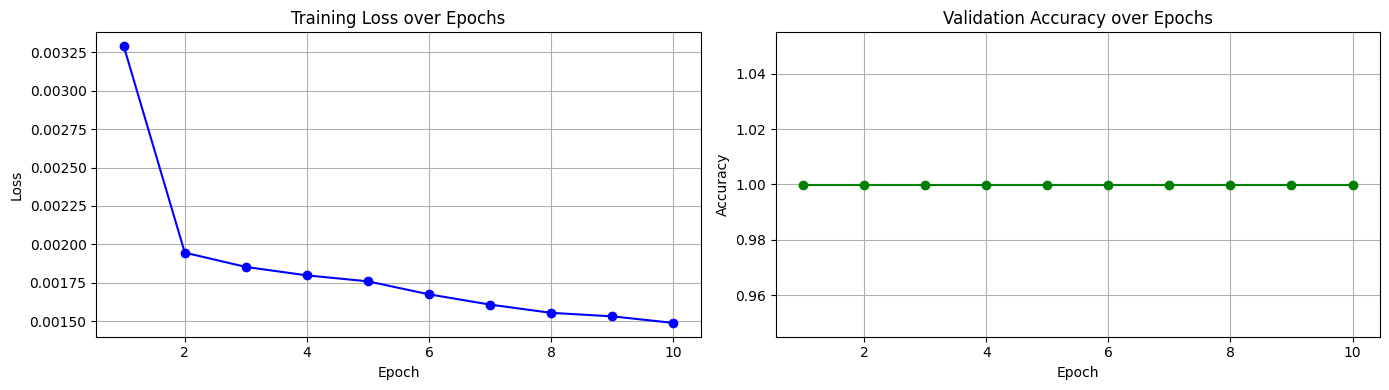

In [15]:
# visualizing training progress
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# plot training loss
ax1.plot(range(1, num_epochs+1), train_losses, marker='o', color='blue')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss over Epochs')
ax1.grid(True)

# plot validation accuracy
ax2.plot(range(1, num_epochs+1), val_accuracies, marker='o', color='green')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Validation Accuracy over Epochs')
ax2.grid(True)

plt.tight_layout()
plt.show()

## Step 6: Final Evaluation

Now let's see how well our model performs on all three datasets!

In [16]:
# function to evaluate the model on any dataset
def evaluate_model(data_loader, dataset_name):
    model.eval()
    accuracy_metric = Accuracy(task="binary")
    
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs.data, 1)
            accuracy_metric.update(predicted, y_batch)
    
    accuracy = accuracy_metric.compute().item()
    print(f"{dataset_name} Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    return accuracy

In [17]:
# evaluating on all datasets
print("="*50)
print("FINAL MODEL PERFORMANCE")
print("="*50 + "\n")

train_acc = evaluate_model(train_loader, "Training Set  ")
val_acc = evaluate_model(val_loader, "Validation Set")
test_acc = evaluate_model(test_loader, "Test Set      ")

print("\n" + "="*50)

FINAL MODEL PERFORMANCE

Training Set   Accuracy: 0.9997 (99.97%)
Validation Set Accuracy: 1.0000 (100.00%)
Test Set       Accuracy: 0.9460 (94.60%)



## Step 7: Understanding the Results

Let me look at some predictions to understand what the model is doing.

In [18]:
# getting some predictions from the test set
model.eval()

# get first batch from test set
test_iter = iter(test_loader)
X_sample, y_sample = next(test_iter)

with torch.no_grad():
    outputs = model(X_sample)
    probabilities = F.softmax(outputs, dim=1)
    _, predictions = torch.max(outputs, 1)

# showing first 10 predictions
print("Sample Predictions (first 10):")
print("="*70)
print(f"{'Actual':<10} {'Predicted':<12} {'Confidence (Benign)':<20} {'Confidence (Suspicious)'}")
print("="*70)

for i in range(10):
    actual = "Suspicious" if y_sample[i].item() == 1 else "Benign"
    pred = "Suspicious" if predictions[i].item() == 1 else "Benign"
    conf_benign = probabilities[i][0].item()
    conf_suspicious = probabilities[i][1].item()
    
    print(f"{actual:<10} {pred:<12} {conf_benign:<20.4f} {conf_suspicious:.4f}")

Sample Predictions (first 10):
Actual     Predicted    Confidence (Benign)  Confidence (Suspicious)
Benign     Benign       1.0000               0.0000
Benign     Benign       1.0000               0.0000
Benign     Benign       1.0000               0.0000
Benign     Benign       1.0000               0.0000
Benign     Benign       1.0000               0.0000
Benign     Benign       1.0000               0.0000
Benign     Benign       1.0000               0.0000
Benign     Benign       1.0000               0.0000
Benign     Benign       1.0000               0.0000
Benign     Benign       1.0000               0.0000


In [19]:
# let's calculate some more detailed metrics for the test set
from sklearn.metrics import confusion_matrix, classification_report

model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.numpy())
        all_labels.extend(y_batch.numpy())

# confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, 
                          target_names=['Benign', 'Suspicious']))

Confusion Matrix:
[[ 17508      0]
 [ 10208 161251]]

Classification Report:
              precision    recall  f1-score   support

      Benign       0.63      1.00      0.77     17508
  Suspicious       1.00      0.94      0.97    171459

    accuracy                           0.95    188967
   macro avg       0.82      0.97      0.87    188967
weighted avg       0.97      0.95      0.95    188967



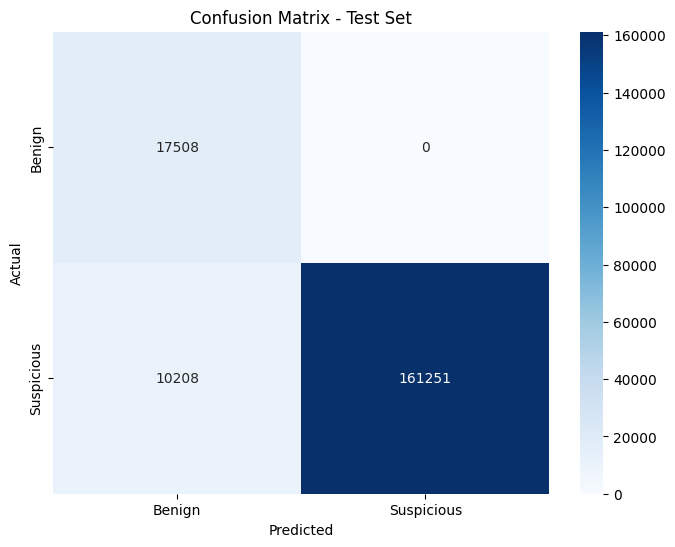

In [20]:
# visualizing confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Benign', 'Suspicious'],
            yticklabels=['Benign', 'Suspicious'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Set')
plt.show()

## Conclusion

I've successfully built and trained a neural network to detect cybersecurity threats!

**Key Takeaways:**
- The model learned to distinguish between benign and suspicious network events
- Deep learning can be effective for cybersecurity threat detection
- The BETH dataset provided good training data for this task

**Possible Improvements:**
- Try different architectures (more layers, different sizes)
- Experiment with learning rates and batch sizes
- Use techniques like dropout to prevent overfitting
- Try other optimizers (SGD, RMSprop)
- Address class imbalance if present

In [ ]:
# optionally save the model
# torch.save(model.state_dict(), '../models/cyber_threat_detector.pth')
# print("Model saved!")